In [1]:
%load_ext autoreload
%autoreload 2

# Example of SasRec training/inference with Parquet Module

In [2]:
from typing import Optional

import lightning as L
import pandas as pd

L.seed_everything(42)

import warnings
warnings.filterwarnings("ignore")

Seed set to 42


## Preparing data
In this example, we will be using the MovieLens dataset, namely the 1m subset. It's demonstrated a simple case, so only item ids will be used as model input.

---
**NOTE**

Current implementation of SasRec is able to handle item and interactions features. It does not take into account user features. 

---

In [3]:
interactions = pd.read_csv("./data/ml1m_ratings.dat", sep="\t", names=["user_id", "item_id","rating","timestamp"])
interactions = interactions.drop(columns=["rating"])

In [4]:
interactions["timestamp"] = interactions["timestamp"].astype("int64")
interactions = interactions.sort_values(by="timestamp")
interactions["timestamp"] = interactions.groupby("user_id").cumcount()
interactions

,user_id,item_id,timestamp
1000138,6040,858,0
1000153,6040,2384,1
999873,6040,593,2
1000007,6040,1961,3
1000192,6040,2019,4
...,...,...,...
825793,4958,2399,446
825438,4958,1407,447
825724,4958,3264,448
825731,4958,2634,449


### Encode catagorical data.
To ensure all categorical data is fit for training, it needs to be encoded using the `LabelEncoder` class. Create an instance of the encoder, providing a `LabelEncodingRule` for each categorcial column in the dataset that will be used in model. Note that ids of users and ids of items are always used.

In [5]:
from replay.preprocessing.label_encoder import LabelEncoder, LabelEncodingRule

encoder = LabelEncoder(
    [
        LabelEncodingRule("user_id", default_value="last"),
        LabelEncodingRule("item_id", default_value="last"),
    ]
)
interactions = interactions.sort_values(by="item_id", ascending=True)
encoded_interactions = encoder.fit_transform(interactions)
encoded_interactions

,timestamp,user_id,item_id
0,12,0,0
1,68,1,0
2,67,2,0
3,12,3,0
4,140,4,0
...,...,...,...
1000204,14,4555,3705
1000205,90,2813,3705
1000206,70,2404,3705
1000207,25,5835,3705


### Split interactions into the train, validation and test datasets using LastNSplitter
We use widespread splitting strategy Last-One-Out. We filter out cold items and users for simplicity.

In [6]:
from replay.splitters import LastNSplitter

splitter = LastNSplitter(
    N=1,
    divide_column="user_id",
    query_column="user_id",
    strategy="interactions",
    drop_cold_users=True,
    drop_cold_items=True
)

test_events, test_gt = splitter.split(encoded_interactions)
validation_events, validation_gt = splitter.split(test_events)
train_events = validation_events

### Dataset preprocessing ("baking")
SasRec expects each user in the batch to provide their events in form of a sequence. For this reason, the event splits must be properly processed using the `groupby_sequences` function provided by RePlay.

In [7]:
from replay.data.nn.utils import groupby_sequences


def bake_data(full_data):
    grouped_interactions = groupby_sequences(events=full_data, groupby_col="user_id", sort_col="timestamp")
    return grouped_interactions

In [8]:
train_events = bake_data(train_events)

validation_events = bake_data(validation_events)
validation_gt = bake_data(validation_gt)

test_events = bake_data(test_events)
test_gt = bake_data(test_gt)

train_events

,user_id,timestamp,item_id
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[2426, 822, 2733, 2587, 2937, 3618, 2943, 708,..."
1,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[3272, 3026, 2760, 851, 346, 3393, 1107, 515, ..."
2,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[579, 1140, 1154, 2426, 1524, 1260, 2160, 2621..."
3,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1781, 2940, 2468, 890, 948, 106, 593, 309, 49..."
4,4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1108, 2229, 21, 2435, 2142, 106, 1167, 593, 1..."
...,...,...,...
6035,6035,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[2426, 1279, 3151, 3321, 1178, 3301, 2501, 278..."
6036,6036,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1592, 2302, 1633, 1813, 2879, 1482, 2651, 250..."
6037,6037,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1971, 3500, 2077, 1666, 1399, 2651, 2748, 283..."
6038,6038,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1486, 1485, 3384, 3512, 3302, 3126, 3650, 330..."


To ensure we don't have unknown users in ground truth, we join validation events and validation ground truth (also join test events and test ground truth correspondingly) by user ids to leave only the common ones.  

In [9]:
def add_gt_to_events(events_df, gt_df):
    gt_to_join = gt_df[["user_id", "item_id"]].rename(columns={"item_id": "ground_truth"})

    events_df = events_df.merge(gt_to_join, on="user_id", how="inner")
    return events_df

validation_events = add_gt_to_events(validation_events, validation_gt)
test_events = add_gt_to_events(test_events, test_gt)

In [10]:
from pathlib import Path

data_dir = Path("temp/data/")
data_dir.mkdir(parents=True, exist_ok=True)

TRAIN_PATH = data_dir / "train.parquet"
VAL_PATH = data_dir / "val.parquet"
PREDICT_PATH = data_dir / "test.parquet"

ENCODER_PATH = data_dir / "encoder"

In [11]:
train_events.to_parquet(TRAIN_PATH)
validation_events.to_parquet(VAL_PATH)
test_events.to_parquet(PREDICT_PATH)

encoder.save(ENCODER_PATH)

# Prepare to model training
### Create the tensor schema
A schema shows the correspondence of columns from the source dataset with the internal representation of tensors inside the model. It is required by the SasRec model to correctly create embeddings for every source column. Note that user_id does not required in `TensorSchema`.

Note that the **padding value** is the next value (item_id) after the last one. **Cardinality** is the number of unique values ​​given the padding value.

In [12]:
from replay.data import FeatureHint, FeatureType
from replay.data.nn import TensorFeatureInfo, TensorSchema


EMBEDDING_DIM = 64

encoder = encoder.load(ENCODER_PATH)
NUM_UNIQUE_ITEMS = len(encoder.mapping["item_id"])

tensor_schema = TensorSchema(
    [
        TensorFeatureInfo(
            name="item_id",
            is_seq=True,
            padding_value=NUM_UNIQUE_ITEMS,
            cardinality=NUM_UNIQUE_ITEMS + 1,  # taking into account padding
            embedding_dim=EMBEDDING_DIM,
            feature_type=FeatureType.CATEGORICAL,
            feature_hint=FeatureHint.ITEM_ID,
        )
    ]
)

### Configure ParquetModule and transformation pipelines

The `ParquetModule` class enables training of models on large datasets by reading data in batch-wise way. This class initialized with **paths to every data split, a metadata dict containing information about shape and padding value of every column and a dict of transforms**. `ParquetModule`'s  "transform pipelines" are stage-specific modules implementing additional preprocessing to be performed on batch level right before the forward pass.  

For SasRec model, RePlay provides a function that generates a sequence of appropriate transforms for each data split named **make_default_sasrec_transforms**.

Internally this function creates the following transforms:
1) Training:
    1. Create a target, which contains the shifted item sequence that represents the next item in the sequence (for the next item prediction task).
    2. Rename features to match it with expected format by the model during training.
    3. Unsqueeze target (*positive_labels*) and it's padding mask (*target_padding_mask*) for getting required shape of this tensors for loss computation.
    4. Group input features to be embed in expected format.

2) Validation/Inference:
    1. Rename/group features to match it with expected format by the model during valdiation/inference.

If a different set of transforms is required, you can create them yourself and submit them to the ParquetModule in the form of a dictionary where the key is the name of the split, and the value is the list of transforms. Available transforms are in the replay/nn/transforms/.

**Note:** One of the transforms for the training data prepares the initial sequence for the task of Next Item Prediction so it shifts the sequence of items. For the final sequence length to be correct, you need to set shape of item_id in metadata as **model sequence length + shift**. Default shift value is 1.

In [13]:
from replay.nn.transform.template import make_default_sasrec_transforms

transforms = make_default_sasrec_transforms(tensor_schema, query_column="user_id")

In [14]:
MAX_SEQ_LEN = 50

def create_meta(shape: int, gt_shape: Optional[int] = None):
    meta = {
        "user_id": {},
        "item_id": {"shape": shape, "padding": tensor_schema["item_id"].padding_value},
    }
    if gt_shape is not None:
        meta.update({"ground_truth": {"shape": gt_shape, "padding": -1}})

    return meta

train_metadata = {
    "train": create_meta(shape=MAX_SEQ_LEN+1),
    "validate": create_meta(shape=MAX_SEQ_LEN, gt_shape=1),
}

In [15]:
from replay.data.nn import ParquetModule

BATCH_SIZE = 32

parquet_module = ParquetModule(
    train_path=TRAIN_PATH,
    validate_path=VAL_PATH,
    batch_size=BATCH_SIZE,
    metadata=train_metadata,
    transforms=transforms,
)

## Train model
### Create SasRec model instance and run the training stage using lightning
We may now train the model using the Lightning trainer class. 

RePlay's implementation of SasRec is designed in a modular, **block-based approach**. Instead of passing configuration parameters to the constructor, SasRec is now built by providing fully initialized components that makes the model more flexible and easier to extend.

#### Default Configuration

Default SasRec model may be created quickly via method **from_params**. Default model instance has CE loss, original SasRec transformer layes, and embeddings are aggregated via sum.

In [16]:
from replay.nn.sequential import SasRec

NUM_BLOCKS = 2
NUM_HEADS = 2
DROPOUT = 0.3

sasrec = SasRec.from_params(
    schema=tensor_schema,
    embedding_dim=EMBEDDING_DIM,
    max_sequence_length=MAX_SEQ_LEN,
    num_heads=NUM_HEADS,
    num_blocks=NUM_BLOCKS,
    dropout=DROPOUT,
    loss_type="InBatchFourier",
)

A universal PyTorch Lightning module is provided. It can work with any NN model.

In [17]:
from replay.nn.lightning.optimizer import OptimizerFactory
from replay.nn.lightning.scheduler import LRSchedulerFactory
from replay.nn.lightning import LightningModule

model = LightningModule(
    sasrec,
    optimizer_factory=OptimizerFactory(learning_rate=5e-3),
    lr_scheduler_factory=LRSchedulerFactory(),
)

To facilitate training, we add the following callbacks:
1) `ModelCheckpoint` - to save the best trained model based on its Recall metric. It's a default Lightning Callback.
1) `ComputeMetricsCallback` - to display a detailed validation metric matrix after each epoch. It's a custom RePlay callback for computing recsys metrics on validation and test stages.


In [18]:
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

from replay.nn.lightning.callback import ComputeMetricsCallback


checkpoint_callback = ModelCheckpoint(
    dirpath="sasrec/checkpoints",
    save_top_k=1,
    verbose=True,
    monitor="recall@10",
    mode="max",
)

validation_metrics_callback = ComputeMetricsCallback(
    metrics=["map", "ndcg", "recall"],
    ks=[1, 5, 10, 20, 30],
    item_count=NUM_UNIQUE_ITEMS,
)

csv_logger = CSVLogger(save_dir="sasrec/logs/train", name="SasRec-example")

trainer = L.Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, validation_metrics_callback],
    logger=csv_logger,
)

trainer.fit(model, datamodule=parquet_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode  | FLOPs
-------------------------------------------------
0 | model | SasRec | 291 K  | train | 0    
-------------------------------------------------
291 K     Trainable params
0         Non-trainable params
291 K     Total params
1.164     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 189: 'recall@10' reached 0.05216 (best 0.05216), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=0-step=189-v1.ckpt' as top 1


k              1        10        20        30         5
map     0.007286  0.017165  0.020326  0.021948  0.014059
ndcg    0.007286  0.025179  0.036750  0.045397  0.017515
recall  0.007286  0.052161  0.098029  0.138765  0.028150



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 378: 'recall@10' reached 0.08329 (best 0.08329), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=1-step=378-v2.ckpt' as top 1


k              1        10        20        30         5
map     0.007452  0.024225  0.029011  0.031400  0.018554
ndcg    0.007452  0.037759  0.055430  0.068060  0.023976
recall  0.007452  0.083292  0.153668  0.212949  0.040570



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 567: 'recall@10' reached 0.10200 (best 0.10200), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=2-step=567.ckpt' as top 1


k              1        10        20        30         5
map     0.007948  0.028788  0.034131  0.036638  0.022493
ndcg    0.007948  0.045582  0.065408  0.078670  0.030107
recall  0.007948  0.102004  0.181156  0.243418  0.053651



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 756: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.007617  0.027663  0.033779  0.036758  0.021397
ndcg    0.007617  0.044159  0.066792  0.082653  0.028868
recall  0.007617  0.099520  0.189767  0.264448  0.051995



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 945: 'recall@10' reached 0.11889 (best 0.11889), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=4-step=945-v4.ckpt' as top 1


k              1        10        20        30         5
map     0.008776  0.032842  0.039118  0.042304  0.025352
ndcg    0.008776  0.052566  0.075728  0.092707  0.034134
recall  0.008776  0.118894  0.211128  0.291108  0.061268



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 1134: 'recall@10' reached 0.12635 (best 0.12635), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=5-step=1134.ckpt' as top 1


k              1        10        20        30         5
map     0.010267  0.034960  0.041191  0.044241  0.026536
ndcg    0.010267  0.055824  0.079068  0.095411  0.035137
recall  0.010267  0.126345  0.219407  0.296572  0.061765



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 1323: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.008445  0.033715  0.040416  0.043816  0.025609
ndcg    0.008445  0.054047  0.078760  0.096695  0.034240
recall  0.008445  0.122371  0.220732  0.304852  0.060772



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 1512: 'recall@10' reached 0.13164 (best 0.13164), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=7-step=1512.ckpt' as top 1


k              1        10        20        30         5
map     0.007783  0.035467  0.041997  0.045144  0.027099
ndcg    0.007783  0.057567  0.081817  0.098489  0.037060
recall  0.007783  0.131644  0.228515  0.306839  0.067726



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 1701: 'recall@10' reached 0.13529 (best 0.13529), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=8-step=1701.ckpt' as top 1


k              1        10        20        30         5
map     0.009107  0.037313  0.044939  0.047941  0.028785
ndcg    0.009107  0.059829  0.087898  0.103819  0.039006
recall  0.009107  0.135287  0.246895  0.321742  0.070541



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 1890: 'recall@10' was not in top 1


k             1        10        20        30         5
map     0.00712  0.034642  0.041987  0.045213  0.026196
ndcg    0.00712  0.057006  0.084038  0.101154  0.036234
recall  0.00712  0.132141  0.239609  0.320086  0.067230



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 2079: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006789  0.036395  0.043806  0.046942  0.027999
ndcg    0.006789  0.058779  0.085924  0.102452  0.038306
recall  0.006789  0.133466  0.241100  0.318596  0.069879



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 2268: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.007783  0.034890  0.041846  0.045207  0.026321
ndcg    0.007783  0.057165  0.083078  0.100952  0.035892
recall  0.007783  0.132307  0.235966  0.320086  0.065408



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 2457: 'recall@10' reached 0.13926 (best 0.13926), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=12-step=2457.ckpt' as top 1


k              1        10        20        30         5
map     0.003809  0.035269  0.042505  0.045596  0.026853
ndcg    0.003809  0.059252  0.085952  0.102386  0.038512
recall  0.003809  0.139261  0.245570  0.322901  0.074350



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 2646: 'recall@10' reached 0.14903 (best 0.14903), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=13-step=2646.ckpt' as top 1


k              1        10        20        30         5
map     0.006458  0.038941  0.045858  0.049118  0.029492
ndcg    0.006458  0.064268  0.089962  0.107331  0.041011
recall  0.006458  0.149031  0.251697  0.333499  0.076337



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 2835: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006458  0.036005  0.043354  0.046606  0.026826
ndcg    0.006458  0.060096  0.087434  0.104691  0.037521
recall  0.006458  0.141083  0.250373  0.331512  0.070541



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 3024: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005961  0.036355  0.044018  0.047178  0.028037
ndcg    0.005961  0.059816  0.088095  0.104886  0.039393
recall  0.005961  0.138102  0.250704  0.329690  0.074350



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 3213: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006292  0.036396  0.043858  0.047060  0.028219
ndcg    0.006292  0.059781  0.087044  0.103925  0.039561
recall  0.006292  0.137937  0.245902  0.325054  0.074516



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 3402: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006127  0.036266  0.043295  0.046737  0.027154
ndcg    0.006127  0.060758  0.086872  0.105171  0.038501
recall  0.006127  0.142904  0.247226  0.333333  0.073688



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 3591: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006955  0.036596  0.043638  0.046942  0.027620
ndcg    0.006955  0.060489  0.086563  0.104076  0.038366
recall  0.006955  0.140752  0.244743  0.327041  0.071535



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 3780: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006292  0.036902  0.043911  0.047290  0.028410
ndcg    0.006292  0.060209  0.086053  0.103980  0.039606
recall  0.006292  0.137771  0.240603  0.324888  0.074019



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 3969: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006127  0.036398  0.043758  0.047154  0.026986
ndcg    0.006127  0.060659  0.087899  0.105929  0.037477
recall  0.006127  0.142242  0.250869  0.335652  0.069714



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 4158: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004802  0.035864  0.043010  0.046529  0.027027
ndcg    0.004802  0.060017  0.086500  0.105144  0.038196
recall  0.004802  0.140917  0.246564  0.334161  0.072529



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 4347: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006789  0.038750  0.046162  0.049377  0.029464
ndcg    0.006789  0.063264  0.090766  0.107891  0.040517
recall  0.006789  0.145223  0.255009  0.335652  0.074350



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 4536: 'recall@10' was not in top 1


k             1        10        20        30         5
map     0.00563  0.035181  0.042472  0.045878  0.026056
ndcg    0.00563  0.059430  0.086613  0.104706  0.036816
recall  0.00563  0.141083  0.249876  0.334989  0.070045



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 4725: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005796  0.037811  0.044962  0.048487  0.029238
ndcg    0.005796  0.062127  0.088644  0.107297  0.041038
recall  0.005796  0.143236  0.249048  0.336645  0.077331



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 4914: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005464  0.036462  0.044152  0.047221  0.027662
ndcg    0.005464  0.060562  0.088931  0.105181  0.038995
recall  0.005464  0.141083  0.254016  0.330353  0.073853



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 5103: 'recall@10' was not in top 1


k             1        10        20        30         5
map     0.00712  0.036825  0.044774  0.048233  0.027979
ndcg    0.00712  0.060475  0.090020  0.108297  0.038766
recall  0.00712  0.139758  0.257824  0.343600  0.072032



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 5292: 'recall@10' was not in top 1


k             1        10        20        30         5
map     0.00563  0.036066  0.043307  0.046688  0.026735
ndcg    0.00563  0.060505  0.087101  0.104908  0.037622
recall  0.00563  0.142573  0.248220  0.331677  0.071204



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 5481: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005299  0.036378  0.043885  0.047233  0.026552
ndcg    0.005299  0.061001  0.088976  0.106681  0.036964
recall  0.005299  0.143732  0.255671  0.338798  0.068886



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 5670: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005796  0.036393  0.043910  0.047118  0.026969
ndcg    0.005796  0.060752  0.088602  0.105543  0.037771
recall  0.005796  0.142408  0.253519  0.333002  0.071038



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 5859: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005299  0.035419  0.043520  0.046762  0.026798
ndcg    0.005299  0.058692  0.088562  0.105828  0.037587
recall  0.005299  0.136446  0.255340  0.336645  0.070707



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 6048: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006458  0.037473  0.044886  0.048183  0.027585
ndcg    0.006458  0.062409  0.089912  0.107488  0.038055
recall  0.006458  0.146382  0.256168  0.338963  0.070210



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 6237: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005464  0.036277  0.043798  0.046993  0.027168
ndcg    0.005464  0.060982  0.088839  0.105733  0.038478
recall  0.005464  0.143898  0.255009  0.334327  0.073357



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 6426: 'recall@10' was not in top 1


k             1        10        20        30         5
map     0.00563  0.036518  0.044171  0.047524  0.027383
ndcg    0.00563  0.060626  0.088730  0.106518  0.038375
recall  0.00563  0.141249  0.252856  0.336480  0.072197



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 6615: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004305  0.034751  0.042122  0.045646  0.025832
ndcg    0.004305  0.058592  0.085712  0.104362  0.036721
recall  0.004305  0.138434  0.246233  0.333830  0.070210



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 6804: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004968  0.036049  0.042811  0.046351  0.026293
ndcg    0.004968  0.061321  0.086245  0.105019  0.037444
recall  0.004968  0.146216  0.245405  0.333665  0.071866



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 6993: 'recall@10' was not in top 1


k             1        10        20        30         5
map     0.00563  0.036995  0.044810  0.048100  0.027971
ndcg    0.00563  0.061684  0.090622  0.108039  0.039450
recall  0.00563  0.144395  0.259811  0.341613  0.074847



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 7182: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004637  0.034337  0.042831  0.046011  0.025631
ndcg    0.004637  0.058121  0.089253  0.106175  0.036771
recall  0.004637  0.137771  0.261302  0.340950  0.071204



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38, global step 7371: 'recall@10' was not in top 1


k             1        10        20        30         5
map     0.00563  0.037010  0.044657  0.047731  0.027480
ndcg    0.00563  0.061757  0.089960  0.106243  0.038356
recall  0.00563  0.144726  0.256996  0.333499  0.071701



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39, global step 7560: 'recall@10' was not in top 1


k             1        10        20        30         5
map     0.00563  0.036203  0.043930  0.047175  0.026641
ndcg    0.00563  0.060518  0.089098  0.106271  0.037246
recall  0.00563  0.142077  0.256003  0.336645  0.069879



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40, global step 7749: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005464  0.037225  0.044764  0.048106  0.027841
ndcg    0.005464  0.062356  0.090178  0.107823  0.039135
recall  0.005464  0.146713  0.257493  0.340288  0.073853



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41, global step 7938: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005796  0.035310  0.042663  0.046050  0.026056
ndcg    0.005796  0.059337  0.086460  0.104474  0.036591
recall  0.005796  0.140089  0.248054  0.332837  0.069051



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42, global step 8127: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006789  0.038482  0.046172  0.049621  0.029166
ndcg    0.006789  0.063271  0.091555  0.109766  0.040526
recall  0.006789  0.146216  0.258652  0.344097  0.075509



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43, global step 8316: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004305  0.034930  0.042646  0.046189  0.025818
ndcg    0.004305  0.058837  0.087320  0.106200  0.036519
recall  0.004305  0.138930  0.252360  0.341282  0.069382



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44, global step 8505: 'recall@10' was not in top 1


k             1        10        20        30         5
map     0.00712  0.037576  0.045279  0.048769  0.028476
ndcg    0.00712  0.061666  0.090107  0.108630  0.039202
recall  0.00712  0.142573  0.255837  0.342938  0.072197



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45, global step 8694: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006458  0.037961  0.045558  0.049108  0.028208
ndcg    0.006458  0.063082  0.091089  0.109881  0.039305
recall  0.006458  0.147375  0.258818  0.347077  0.073522



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46, global step 8883: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005961  0.037060  0.044919  0.048107  0.027402
ndcg    0.005961  0.061695  0.090743  0.107678  0.037887
recall  0.005961  0.144560  0.260308  0.339957  0.070045



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47, global step 9072: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006127  0.035569  0.043854  0.046846  0.026737
ndcg    0.006127  0.058857  0.089316  0.105223  0.037195
recall  0.006127  0.136943  0.257990  0.332837  0.069382



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48, global step 9261: 'recall@10' was not in top 1


k             1        10        20        30         5
map     0.00712  0.037388  0.044778  0.048297  0.028123
ndcg    0.00712  0.061135  0.088799  0.107418  0.038505
recall  0.00712  0.140752  0.251697  0.339129  0.070376



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49, global step 9450: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.007286  0.036327  0.044023  0.047387  0.027262
ndcg    0.007286  0.059769  0.088201  0.106081  0.037496
recall  0.007286  0.138599  0.251863  0.335983  0.069051



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50, global step 9639: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.007617  0.037329  0.044751  0.048181  0.028101
ndcg    0.007617  0.061501  0.089065  0.107321  0.039034
recall  0.007617  0.142573  0.252691  0.338632  0.072860



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51, global step 9828: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006789  0.037142  0.045001  0.048412  0.028040
ndcg    0.006789  0.061488  0.090345  0.108323  0.038993
recall  0.006789  0.143236  0.257824  0.342110  0.072694



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52, global step 10017: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.008114  0.037323  0.045261  0.048549  0.028390
ndcg    0.008114  0.061027  0.090259  0.107647  0.039076
recall  0.008114  0.140586  0.256831  0.338467  0.072032



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 53, global step 10206: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.007783  0.035409  0.043040  0.046748  0.026586
ndcg    0.007783  0.057942  0.086181  0.105766  0.036257
recall  0.007783  0.133797  0.246398  0.338301  0.066071



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54, global step 10395: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006789  0.036198  0.043907  0.047564  0.027234
ndcg    0.006789  0.059785  0.088178  0.107608  0.037804
recall  0.006789  0.138930  0.251863  0.343269  0.070376



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55, global step 10584: 'recall@10' was not in top 1


k              1        10        20       30         5
map     0.006292  0.034676  0.042420  0.04575  0.025424
ndcg    0.006292  0.058061  0.086604  0.10433  0.035414
recall  0.006292  0.136778  0.250373  0.33383  0.066236



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56, global step 10773: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005796  0.034078  0.042040  0.045524  0.025206
ndcg    0.005796  0.056652  0.086109  0.104697  0.034916
recall  0.005796  0.132472  0.249876  0.337473  0.064746



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57, global step 10962: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006624  0.035256  0.042831  0.046375  0.025934
ndcg    0.006624  0.059014  0.087022  0.105878  0.036229
recall  0.006624  0.138930  0.250538  0.339295  0.068058



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58, global step 11151: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005961  0.035676  0.043832  0.046991  0.026486
ndcg    0.005961  0.059592  0.089780  0.106444  0.037035
recall  0.005961  0.139924  0.260308  0.338467  0.069548



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 59, global step 11340: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005464  0.035097  0.043153  0.046571  0.025691
ndcg    0.005464  0.059372  0.089048  0.107236  0.036223
recall  0.005464  0.141083  0.259149  0.344759  0.068720



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 60, global step 11529: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006789  0.034993  0.042929  0.046503  0.026213
ndcg    0.006789  0.058369  0.087764  0.106768  0.036639
recall  0.006789  0.137109  0.254347  0.343766  0.068886



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 61, global step 11718: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.008114  0.036680  0.044333  0.047923  0.027469
ndcg    0.008114  0.060114  0.088411  0.107462  0.037569
recall  0.008114  0.138930  0.251697  0.341282  0.068720



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 62, global step 11907: 'recall@10' was not in top 1


k             1        10        20        30         5
map     0.00712  0.036695  0.044553  0.047842  0.027248
ndcg    0.00712  0.060704  0.089695  0.107233  0.037424
recall  0.00712  0.141580  0.256996  0.339626  0.068720



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 63, global step 12096: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006127  0.033991  0.042051  0.045588  0.024643
ndcg    0.006127  0.056934  0.086668  0.105391  0.033971
recall  0.006127  0.134459  0.252856  0.340785  0.062759



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 64, global step 12285: 'recall@10' was not in top 1


k             1        10        20        30         5
map     0.00712  0.035401  0.043517  0.047022  0.026185
ndcg    0.00712  0.058589  0.088508  0.107032  0.036042
recall  0.00712  0.136612  0.255671  0.342606  0.066402



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 65, global step 12474: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006789  0.035537  0.043494  0.046882  0.026334
ndcg    0.006789  0.058592  0.088007  0.106000  0.036024
recall  0.006789  0.136115  0.253353  0.337970  0.065739



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 66, global step 12663: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006127  0.034123  0.041806  0.045199  0.024830
ndcg    0.006127  0.057417  0.085999  0.104048  0.034600
recall  0.006127  0.135950  0.250207  0.335155  0.064746



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 67, global step 12852: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.007452  0.035341  0.043372  0.047172  0.027011
ndcg    0.007452  0.057868  0.087430  0.107582  0.037338
recall  0.007452  0.133466  0.251035  0.345753  0.069217



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 68, global step 13041: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.007617  0.035229  0.042961  0.046501  0.026795
ndcg    0.007617  0.057689  0.086469  0.105320  0.036962
recall  0.007617  0.133135  0.248220  0.336976  0.068389



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 69, global step 13230: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006955  0.035576  0.043205  0.047039  0.027000
ndcg    0.006955  0.058181  0.086497  0.106752  0.037183
recall  0.006955  0.133963  0.247061  0.342110  0.068554



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 70, global step 13419: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006292  0.035922  0.043727  0.047096  0.026928
ndcg    0.006292  0.059555  0.088506  0.106468  0.037450
recall  0.006292  0.138930  0.254512  0.339129  0.069879



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 71, global step 13608: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006789  0.036349  0.044176  0.047711  0.027157
ndcg    0.006789  0.060271  0.089221  0.108037  0.037400
recall  0.006789  0.140917  0.256334  0.344925  0.068886



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 72, global step 13797: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006955  0.035467  0.043364  0.046920  0.026525
ndcg    0.006955  0.058579  0.087869  0.106720  0.036743
recall  0.006955  0.136115  0.253022  0.341613  0.068223



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 73, global step 13986: 'recall@10' was not in top 1


k             1        10        20        30         5
map     0.00712  0.036799  0.044820  0.048218  0.027000
ndcg    0.00712  0.060870  0.090726  0.108709  0.036920
recall  0.00712  0.141911  0.261302  0.345753  0.067395



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 74, global step 14175: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005961  0.035279  0.043434  0.046798  0.025887
ndcg    0.005961  0.059189  0.089353  0.107232  0.036026
recall  0.005961  0.139758  0.259977  0.344097  0.067230



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 75, global step 14364: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006624  0.036708  0.044451  0.047881  0.027063
ndcg    0.006624  0.061251  0.089691  0.107972  0.037488
recall  0.006624  0.143898  0.256831  0.342938  0.069548



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 76, global step 14553: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006955  0.036425  0.044471  0.047814  0.026748
ndcg    0.006955  0.060597  0.090377  0.108151  0.036989
recall  0.006955  0.141911  0.260639  0.344262  0.068554



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 77, global step 14742: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.007783  0.037576  0.045849  0.049017  0.028288
ndcg    0.007783  0.062033  0.092809  0.109736  0.039097
recall  0.007783  0.144395  0.267428  0.347243  0.072529



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 78, global step 14931: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.007286  0.036000  0.043786  0.047464  0.027237
ndcg    0.007286  0.059318  0.088325  0.107837  0.037631
recall  0.007286  0.137771  0.253850  0.345587  0.069714



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 79, global step 15120: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005796  0.036407  0.044363  0.047932  0.027124
ndcg    0.005796  0.060861  0.090246  0.109116  0.038150
recall  0.005796  0.142904  0.259977  0.348568  0.072197



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 80, global step 15309: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006955  0.036527  0.044076  0.047555  0.026387
ndcg    0.006955  0.061402  0.089182  0.107713  0.036575
recall  0.006955  0.145388  0.255837  0.343103  0.068058



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 81, global step 15498: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005464  0.034687  0.042580  0.046188  0.025683
ndcg    0.005464  0.058401  0.087656  0.106786  0.036098
recall  0.005464  0.138268  0.255009  0.344925  0.068223



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 82, global step 15687: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006292  0.035743  0.043528  0.047006  0.026525
ndcg    0.006292  0.059825  0.088477  0.106858  0.037053
recall  0.006292  0.140917  0.254844  0.341116  0.069548



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 83, global step 15876: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006789  0.038088  0.045549  0.048935  0.028562
ndcg    0.006789  0.063034  0.090845  0.108710  0.039544
recall  0.006789  0.146879  0.258155  0.341944  0.073357



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 84, global step 16065: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006127  0.036950  0.044678  0.048149  0.027477
ndcg    0.006127  0.061436  0.089966  0.108435  0.038126
recall  0.006127  0.143732  0.257327  0.344262  0.070873



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 85, global step 16254: 'recall@10' was not in top 1


k             1        10        20        30         5
map     0.00712  0.038051  0.045760  0.049257  0.028642
ndcg    0.00712  0.062792  0.091486  0.109970  0.039545
recall  0.00712  0.145885  0.260639  0.347409  0.073025



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 86, global step 16443: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.008776  0.038536  0.045896  0.049540  0.028766
ndcg    0.008776  0.063665  0.090904  0.110366  0.039557
recall  0.008776  0.148535  0.257162  0.348899  0.073025



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 87, global step 16632: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.007948  0.037209  0.044885  0.048436  0.027402
ndcg    0.007948  0.061640  0.089882  0.108751  0.037401
recall  0.007948  0.144229  0.256499  0.345256  0.068223



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 88, global step 16821: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.007948  0.036171  0.044206  0.047699  0.026831
ndcg    0.007948  0.059441  0.089259  0.107762  0.036490
recall  0.007948  0.137937  0.256996  0.343931  0.066236



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 89, global step 17010: 'recall@10' was not in top 1


k             1        10        20        30         5
map     0.00712  0.035220  0.042896  0.046870  0.027011
ndcg    0.00712  0.057954  0.086305  0.107374  0.037573
recall  0.00712  0.134294  0.247226  0.346249  0.070210



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 90, global step 17199: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.009107  0.037915  0.046075  0.049322  0.028810
ndcg    0.009107  0.061527  0.091638  0.108887  0.039213
recall  0.009107  0.140917  0.260805  0.341944  0.071369



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 91, global step 17388: 'recall@10' was not in top 1


k             1        10        20        30         5
map     0.00712  0.037675  0.045348  0.048942  0.027825
ndcg    0.00712  0.062607  0.090764  0.109724  0.038412
recall  0.00712  0.146547  0.258321  0.347243  0.071038



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 92, global step 17577: 'recall@10' reached 0.14953 (best 0.14953), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=92-step=17577-v1.ckpt' as top 1


k              1        10        20        30         5
map     0.008114  0.039549  0.047461  0.051154  0.029652
ndcg    0.008114  0.064761  0.093984  0.113424  0.040432
recall  0.008114  0.149528  0.265938  0.357013  0.073522



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 93, global step 17766: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.008776  0.038438  0.046304  0.049540  0.028647
ndcg    0.008776  0.063046  0.092129  0.109336  0.038915
recall  0.008776  0.146051  0.261964  0.342938  0.070541



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 94, global step 17955: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005796  0.036416  0.044488  0.047906  0.027535
ndcg    0.005796  0.060335  0.089977  0.108090  0.038688
recall  0.005796  0.140255  0.257990  0.343103  0.073025



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 95, global step 18144: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.008445  0.039274  0.046893  0.050524  0.030458
ndcg    0.008445  0.063096  0.091404  0.110670  0.041479
recall  0.008445  0.142739  0.255837  0.346415  0.075344



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 96, global step 18333: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.007948  0.036642  0.044358  0.047659  0.027783
ndcg    0.007948  0.060032  0.088790  0.106248  0.038246
recall  0.007948  0.138599  0.253684  0.335652  0.070541



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 97, global step 18522: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.007617  0.038665  0.046409  0.050010  0.029632
ndcg    0.007617  0.062838  0.091159  0.110254  0.040660
recall  0.007617  0.143732  0.256003  0.345753  0.074516



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 98, global step 18711: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.007783  0.036289  0.044076  0.047640  0.026693
ndcg    0.007783  0.060319  0.089030  0.107941  0.036574
recall  0.007783  0.141580  0.255837  0.344759  0.067064



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 99, global step 18900: 'recall@10' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


k              1        10        20        30         5
map     0.007452  0.037468  0.045448  0.048867  0.028448
ndcg    0.007452  0.061604  0.091109  0.109299  0.039407
recall  0.007452  0.142573  0.260142  0.345753  0.073191



In [24]:
import torch
import matplotlib.pyplot as plt
from replay.nn.loss.fourier.evaluate import evaluate_image

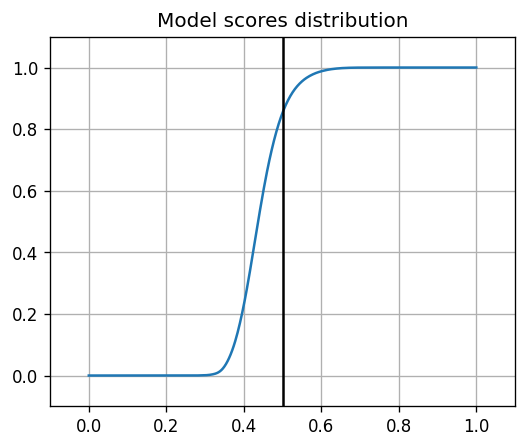

In [25]:
xs = torch.linspace(0.0, 1.0, steps = 501)
img = evaluate_image(model.model.loss.cdf_image.cpu(), xs)

fig = plt.figure(figsize = (5, 4), dpi = 120)
plt.title("Model scores distribution")
plt.plot(xs, img)
plt.xlim(-0.1, +1.1)
plt.ylim(-0.1, +1.1)
plt.axvline(0.5, c = "k")
plt.grid()
plt.show()
plt.close(fig)

Now we can get the best model path stored in the checkpoint callback.

In [26]:
best_model_path = checkpoint_callback.best_model_path
best_model_path

'/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=92-step=17577-v1.ckpt'

## Inference

To obtain model scores, we will load the weights from the best checkpoint. To do this, we use the `LightningModule`, provide there the path to the checkpoint and the model instance.

In [27]:
import replay
torch.serialization.add_safe_globals([
    replay.nn.lightning.optimizer.OptimizerFactory,
    replay.nn.lightning.scheduler.LRSchedulerFactory,
])

In [28]:
sasrec = SasRec.from_params(
    schema=tensor_schema,
    embedding_dim=EMBEDDING_DIM,
    max_sequence_length=MAX_SEQ_LEN,
    num_heads=NUM_HEADS,
    num_blocks=NUM_BLOCKS,
    dropout=DROPOUT,
    excluded_features=None,
    loss_type = "InBatchFourier",
)


best_model = LightningModule.load_from_checkpoint(best_model_path, model=sasrec, weight_only=True)
best_model.eval()

LightningModule(
  (model): SasRec(
    (body): SasRecBody(
      (embedder): SequenceEmbedding(
        (feature_embedders): ModuleDict(
          (item_id): CategoricalEmbedding(
            (emb): Embedding(3707, 64, padding_idx=3706)
          )
        )
      )
      (embedding_aggregator): PositionAwareAggregator(
        (embedding_aggregator): SumAggregator()
        (pe): Embedding(50, 64)
        (dropout): Dropout(p=0.3, inplace=False)
      )
      (encoder): SasRecTransformerLayer(
        (attention_layers): ModuleList(
          (0-1): 2 x MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
        )
        (attention_layernorms): ModuleList(
          (0-1): 2 x LayerNorm((64,), eps=1e-08, elementwise_affine=True)
        )
        (forward_layers): ModuleList(
          (0-1): 2 x PointWiseFeedForward(
            (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
            (dropout

Configure `ParquetModule` for inference

In [29]:
inference_metadata = {"predict": create_meta(shape=MAX_SEQ_LEN)}

parquet_module = ParquetModule(
    predict_path=PREDICT_PATH,
    batch_size=BATCH_SIZE,
    metadata=inference_metadata,
    transforms=transforms,
)

During inference, we can use `TopItemsCallback`. Such callback allows you to get scores for each user throughout the entire catalog and get recommendations in the form of ids of items with the highest score values.


Recommendations can be fetched in four formats: PySpark DataFrame, Pandas DataFrame, Polars DataFrame or raw PyTorch tensors. Each of the types corresponds a callback. In this example, we'll be using the `PandasTopItemsCallback`.

In [30]:
from replay.nn.lightning.callback import PandasTopItemsCallback

csv_logger = CSVLogger(save_dir="sasrec/logs/test", name="SasRec-example")

TOPK = [1, 5, 10, 20]

pandas_prediction_callback = PandasTopItemsCallback(
    top_k=max(TOPK),
    query_column="user_id",
    item_column="item_id",
    rating_column="score",
)

trainer = L.Trainer(callbacks=[pandas_prediction_callback], logger=csv_logger, inference_mode=True)
trainer.predict(best_model, datamodule=parquet_module, return_predictions=False)

pandas_res = pandas_prediction_callback.get_result()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [31]:
pandas_res

,user_id,item_id,score
0,0,101,9.911036
0,0,224,7.510771
0,0,334,7.280517
0,0,1398,7.169092
0,0,2344,7.07904
...,...,...,...
6037,6039,2557,9.692659
6037,6039,3555,9.215297
6037,6039,2865,9.110065
6037,6039,2489,9.001449


### Calculating metrics

*test_gt* is already encoded, so we can use it for computing metrics.

In [32]:
from replay.metrics import MAP, OfflineMetrics, Precision, Recall
from replay.metrics.torch_metrics_builder import metrics_to_df

In [33]:
result_metrics = OfflineMetrics(
    [Recall(TOPK), Precision(TOPK), MAP(TOPK)],
    query_column="user_id",
    rating_column="score",
)(pandas_res, test_gt.explode("item_id"))

In [34]:
metrics_to_df(result_metrics)

k,1,10,20,5
MAP,0.008115,0.041468,0.048139,0.032624
Precision,0.008115,0.015121,0.012454,0.016628
Recall,0.008115,0.151209,0.249089,0.083140


Let's call the `inverse_transform` encoder's function to get the final dataframe with recommendations

In [35]:
encoder.inverse_transform(pandas_res)

,user_id,item_id,score
0,2012,104,9.911036
0,2012,231,7.510771
0,2012,344,7.280517
0,2012,1517,7.169092
0,2012,2539,7.07904
...,...,...,...
6037,5727,2762,9.692659
6037,5727,3798,9.215297
6037,5727,3081,9.110065
6037,5727,2693,9.001449
